# ML Homework2
#### 0756021 張逸群

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
def read_images(filename):
    with open(filename, 'rb') as f:
        # check magic number
        if int.from_bytes(f.read(4), byteorder='big', signed=True) != 0x803:
            raise IOError('File Magic Number Error')
        
        number_images = int.from_bytes(f.read(4), byteorder='big', signed=True)
        number_rows = int.from_bytes(f.read(4), byteorder='big', signed=True)
        number_columns = int.from_bytes(f.read(4), byteorder='big', signed=True)
        
        images_bytes = f.read()
    
    images = np.frombuffer(images_bytes, dtype=np.uint8)
    images = images.reshape(number_images, number_rows, number_columns)
    return images

In [3]:
def read_labels(filename):
    with open(filename, 'rb') as f:
        # check magic number
        if int.from_bytes(f.read(4), byteorder='big', signed=True) != 0x801:
            raise IOError('File Magic Number Error')
        
        number_items = int.from_bytes(f.read(4), byteorder='big', signed=True)
        labels_bytes = f.read()
    
    labels = np.frombuffer(labels_bytes, dtype=np.uint8)
    return labels

In [4]:
X_train = read_images('./train-images-idx3-ubyte')
y_train = read_labels('./train-labels-idx1-ubyte')
X_test = read_images('./t10k-images-idx3-ubyte')
y_test = read_labels('./t10k-labels-idx1-ubyte')

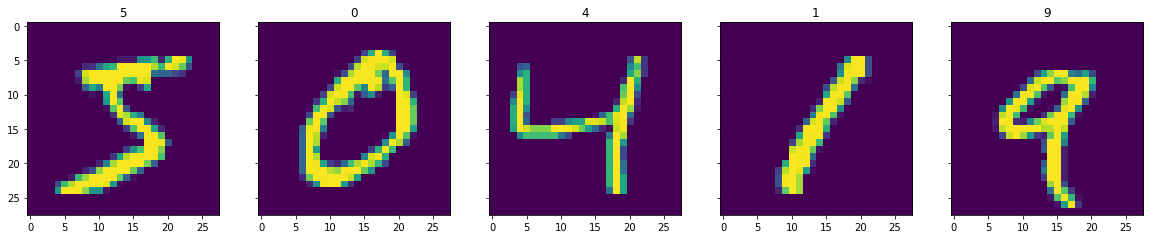

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(20, 10))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i])
    ax.set_title(y_train[i])

## Model Define

![gaussian function](https://wikimedia.org/api/rest_v1/media/math/render/svg/8aa9ff808602c27f1d9d63d7b2c115388a34f190)

In [6]:
def gaussian_function1d(x, mean, var, epsilon=1e-7):
    x = np.array(x)
    if not isinstance(mean, (list, np.ndarray)):
        mean = [mean] * x.shape[0]
    if not isinstance(var, (list, np.ndarray)):
        var = [var] * x.shape[0]
    mean, var =  np.array(mean), np.array(var)
    
    var = var + epsilon

    return np.exp(-0.5 * np.square(x - mean) / var ) / np.sqrt(var * 2. *np.pi)

In [7]:
class NaiveBayesClassifier:
    def __init__(self, discrete=True):
        self.discrete = discrete
        
        self._unique_label = None
        self._likelihood = None
        self._prior = None
        
        self._likelihood_means = None
        self._likelihood_vars = None
    
    def _discrete_fit(self, X, y):
        # do bining
        X = X / 8
        X = X.astype(np.uint8)
        X = X.reshape(X.shape[0], -1)
        
        self._unique_label, y, self._prior = np.unique(y, return_inverse=True, return_counts=True)
        self._prior = self._prior / self._prior.sum()
        number_unique_labels = self._unique_label.shape[0]
        self._likelihood = np.zeros((X.shape[1], 32, number_unique_labels))
        
        # calculate likelihood
        for index_label, label in enumerate(self._unique_label):
            X_match = X[y == label] # (n_sample, n_feature)
            X_histogram = np.apply_along_axis(lambda a: np.histogram(a, bins=np.arange(33))[0], 0, X_match) # (32, n_feature)
            # normalize
            X_histogram = np.apply_along_axis(lambda a: a / a.sum(), 0, X_histogram)
            self._likelihood[:, :, index_label] = np.swapaxes(X_histogram, 0, 1)
        
        return self
    
    def _continuous_fit(self, X, y):
        # don't do bining
        X = X.astype(np.float32)
        X = X.reshape(X.shape[0], -1)
        
        self._unique_label, y, self._prior = np.unique(y, return_inverse=True, return_counts=True)
        self._prior = self._prior / self._prior.sum()
        number_unique_labels = self._unique_label.shape[0]
        
        # calculate mean variance
        self._likelihood_means = np.zeros((X.shape[1], number_unique_labels))
        self._likelihood_vars = np.zeros((X.shape[1], number_unique_labels))
        for index_label, label in enumerate(self._unique_label):
            X_match = X[y == label]
            self._likelihood_means[:, index_label] = np.apply_along_axis(lambda a: a.mean(), 0, X_match)
            self._likelihood_vars[:, index_label] = np.apply_along_axis(lambda a: a.var(), 0, X_match)
            
        return self
    
    def _discrete_predict(self, X, return_postirior=False, epsilon=1e-7):
        # do bining
        X = X / 8
        X = X.astype(np.uint8)
        X = X.reshape(X.shape[0], -1)
        
        # calculate postirior
        postiriors = np.zeros((X.shape[0], self._unique_label.shape[0]))
        
        for index_x, xi in enumerate(X):
            for index_label, label in enumerate(self._unique_label):
                likelihood = -np.log((self._likelihood[:, :, index_label])[[np.arange(xi.shape[0]), xi]] + epsilon).sum()
                postiriors[index_x, index_label] = likelihood + self._prior[index_label]
                
        # marginalize
        postiriors = np.apply_along_axis(lambda a: a / a.sum(), 1, postiriors)
        
        predictions = self._unique_label[np.argmin(postiriors, axis=1)]
        if return_postirior:
            return predictions, postiriors
        return predictions

    def _continuous_predict(self, X, return_postirior=False, epsilon=1e-7):
        # don't do bining
        X = X.astype(np.float32)
        X = X.reshape(X.shape[0], -1)
        
        # calculate postirior
        postiriors = np.zeros((X.shape[0], self._unique_label.shape[0]))
        
        for index_x, xi in enumerate(X):
            for index_label, label in enumerate(self._unique_label):
                likelihood = -np.log(gaussian_function1d(xi, self._likelihood_means[:, index_label], self._likelihood_vars[:, index_label]) + epsilon).sum()
                postiriors[index_x, index_label] = likelihood + self._prior[index_label]
                
        # marginalize
        postiriors = np.apply_along_axis(lambda a: a / a.sum(), 1, postiriors)
        
        predictions = self._unique_label[np.argmin(postiriors, axis=1)]
        if return_postirior:
            return predictions, postiriors
        return predictions
    
    def fit(self, X, y):
        if self.discrete:
            return self._discrete_fit(X, y)
        return self._continuous_fit(X, y)
        
    def predict(self, X, return_postirior=False):
        if self.discrete:
            return self._discrete_predict(X, return_postirior)
        return self._continuous_predict(X, return_postirior)
    
    def score(self, X, y):
        y_true = y
        y_pred = self.predict(X)
        return (y_true == y_pred).sum() / y_true.shape[0]
    
    def print_result(self, X, y):
        predictions, postiriors = self.predict(X, return_postirior=True)
        unique_label = clf._unique_label

        for true, pred, post in zip(y, predictions, postiriors):
            print('Postirior (in log scale):')
            for i in range(10):
                print('{}: {}'.format(i, post[np.argwhere(unique_label == i)][0][0]))
            print('Prediction: {}, Ans: {}'.format(pred, true))
            print()

        print('Imagination of numbers in Bayesian classifier:')
        fig, axes = plt.subplots(ncols=5, nrows=2, sharex=True, sharey=True, figsize=(20, 8))
        if self.discrete:
            for i, ax in enumerate(axes.flatten()):
                white = self._likelihood[:, -16:, np.argwhere(unique_label == i)[0][0]].sum(axis=1)
                black = self._likelihood[:, :-16, np.argwhere(unique_label == i)[0][0]].sum(axis=1)
                ax.imshow((white > black).reshape(28, 28))
            plt.show()
        else:
            for i, ax in enumerate(axes.flatten()):
                lable_index = np.argwhere(unique_label == i)[0][0]
                number_features = self._likelihood_means.shape[0]
                white = np.zeros((28*28, ))
                black = np.zeros((28*28, ))
                for i in range(128):
                    black = black + gaussian_function1d(np.ones(number_features)*i, self._likelihood_means[:, lable_index], self._likelihood_vars[:, lable_index])
                for i in range(128, 256):
                    white = white + gaussian_function1d(np.ones(number_features)*i, self._likelihood_means[:, lable_index], self._likelihood_vars[:, lable_index])
                    
                ax.imshow((white > black).reshape(28, 28))
            plt.show()

## Discrete Mode

In [8]:
clf = NaiveBayesClassifier()
clf.fit(X_train, y_train)

### Result

/home/toosyou/.local/lib/python3.6/site-packages/ipykernel_launcher.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Postirior (in log scale):
0: 0.11167071358562611
1: 0.12885145433589454
2: 0.10717882425073756
3: 0.09787998700706964
4: 0.0919469152442608
5: 0.09433743186440392
6: 0.12188630730714606
7: 0.06994659050239357
8: 0.09524303012127473
9: 0.08105874578119314
Prediction: 7, Ans: 7

Postirior (in log scale):
0: 0.099064350444062
1: 0.10948544576876561
2: 0.0762216645792322
3: 0.08849210429989515
4: 0.10802791681076096
5: 0.08975745350808305
6: 0.08627219824579208
7: 0.1279230031642965
8: 0.09570605803757833
9: 0.11904980514153404
Prediction: 2, Ans: 2

Postirior (in log scale):
0: 0.1280027475641862
1: 0.06286148462073891
2: 0.0976931203520886
3: 0.0996913755417919
4: 0.10254390193042452
5: 0.09563860060416138
6: 0.10251259952165857
7: 0.1060605036545661
8: 0.09938350538338815
9: 0.1056121608269956
Prediction: 1, Ans: 1

Imagination of numbers in Bayesian classifier:


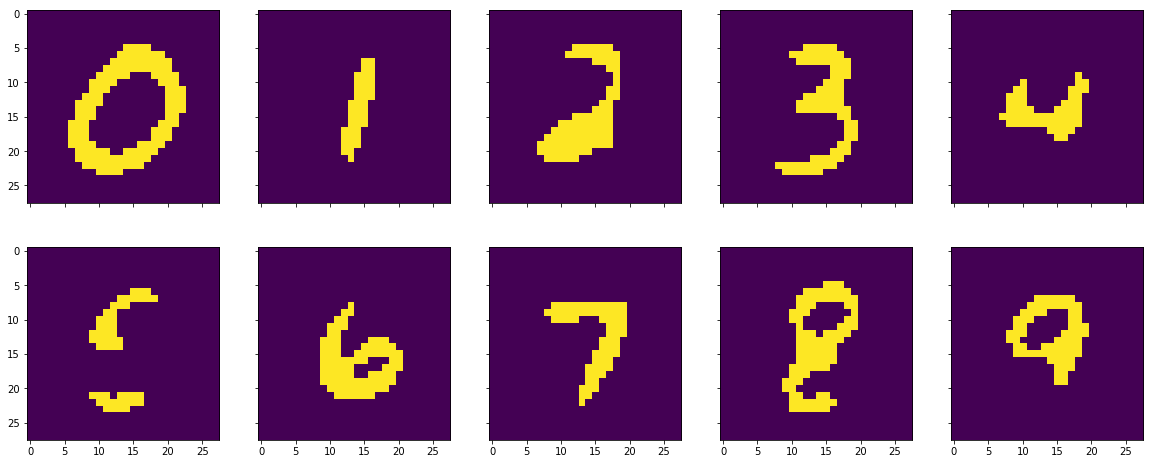

Training error rate: 0.136, Testing error rate: 0.149


In [9]:
clf.print_result(X_test[:3], y_test[:3])
print('Training error rate: {:.3f}, Testing error rate: {:.3f}'.format(1. - clf.score(X_train, y_train), 1. - clf.score(X_test, y_test)))

## Continuous Mode

In [10]:
clf = NaiveBayesClassifier(discrete=False)
clf.fit(X_train, y_train)

Postirior (in log scale):
0: 0.09988498023614496
1: 0.09525875830255805
2: 0.13852338499939132
3: 0.10449948421022329
4: 0.10646129291419569
5: 0.1117968909009327
6: 0.1081796101716324
7: 0.08262408014038905
8: 0.08696636287389643
9: 0.06580515525063611
Prediction: 9, Ans: 7

Postirior (in log scale):
0: 0.09011019884646337
1: 0.08495849664074767
2: 0.10459712998924398
3: 0.09708815155345259
4: 0.12089922864706336
5: 0.10457492981843286
6: 0.0761034777182016
7: 0.13176854874399602
8: 0.08871606439091229
9: 0.10118377365148645
Prediction: 6, Ans: 2

Postirior (in log scale):
0: 0.10867806324752165
1: 0.04386247018149467
2: 0.1389968357239162
3: 0.1119316326135451
4: 0.11711852750284969
5: 0.11667529009419778
6: 0.08811956392432992
7: 0.10995948285973853
8: 0.0883556656392217
9: 0.07630246821318454
Prediction: 1, Ans: 1

Imagination of numbers in Bayesian classifier:


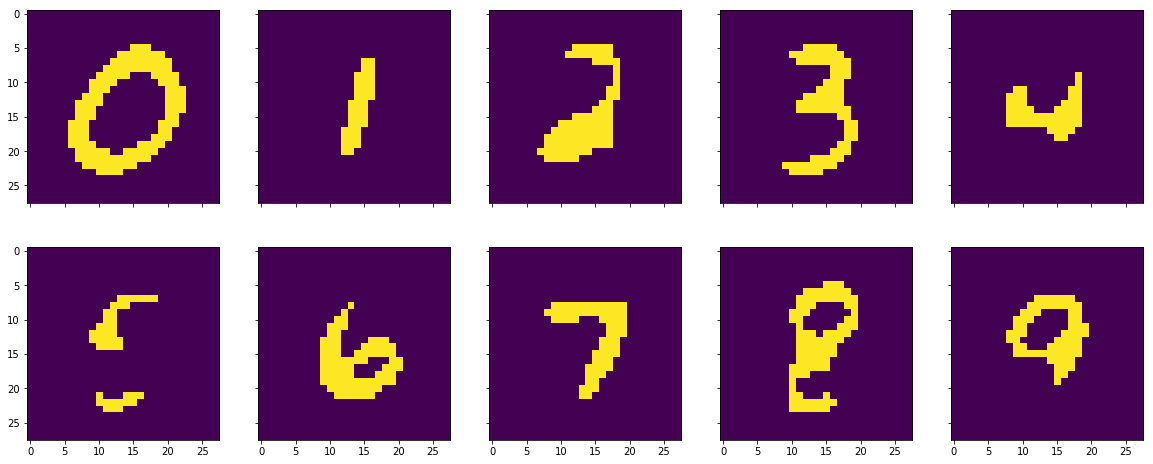

Training error rate: 0.581, Testing error rate: 0.579


In [11]:
clf.print_result(X_test[:3], y_test[:3])
print('Training error rate: {:.3f}, Testing error rate: {:.3f}'.format(1. - clf.score(X_train, y_train), 1. - clf.score(X_test, y_test)))

## Online Learning

## Load Data

In [12]:
with open('testfile.txt', 'r') as f:
    coin_sequences = [ s.strip('\n') for s in f.readlines() ] # read file and remove \n
print(coin_sequences)

['0101010101001011010101', '0110101', '010110101101', '0101101011101011010', '111101100011110', '101110111000110', '1010010111', '11101110110', '01000111101', '110100111', '01101010111']


## Result

In [35]:
def coin_likelihood(sequence):
    head_count = sequence.count('1')
    tail_count = sequence.count('0')
    p = head_count / (head_count + tail_count)
    return comb(head_count+tail_count, head_count, ) * np.power(p, head_count) * np.power(1.-p, tail_count)

In [36]:
A, B = 0, 0
for i, cs in enumerate(coin_sequences):
    print('case {}: {}'.format(i, cs))
    print('Likelihood:', coin_likelihood(cs))
    print('Beta prior:     a = {}  b = {}'.format(A, B))
    A, B = A+cs.count('1'), B+cs.count('0')
    print('Beta posterior: a = {}  b = {}'.format(A, B))
    print()

case 0: 0101010101001011010101
Likelihood: 0.16818809509277344
Beta prior:     a = 0  b = 0
Beta posterior: a = 11  b = 11

case 1: 0110101
Likelihood: 0.29375515303997485
Beta prior:     a = 11  b = 11
Beta posterior: a = 15  b = 14

case 2: 010110101101
Likelihood: 0.2286054241794335
Beta prior:     a = 15  b = 14
Beta posterior: a = 22  b = 19

case 3: 0101101011101011010
Likelihood: 0.18286870706509092
Beta prior:     a = 22  b = 19
Beta posterior: a = 33  b = 27

case 4: 111101100011110
Likelihood: 0.2143070548857833
Beta prior:     a = 33  b = 27
Beta posterior: a = 43  b = 32

case 5: 101110111000110
Likelihood: 0.20659760529408
Beta prior:     a = 43  b = 32
Beta posterior: a = 52  b = 38

case 6: 1010010111
Likelihood: 0.25082265600000003
Beta prior:     a = 52  b = 38
Beta posterior: a = 58  b = 42

case 7: 11101110110
Likelihood: 0.2619678932864457
Beta prior:     a = 58  b = 42
Beta posterior: a = 66  b = 45

case 8: 01000111101
Likelihood: 0.23609128871506807
Beta prior:  

In [37]:
A, B = 10, 1
for i, cs in enumerate(coin_sequences):
    print('case {}: {}'.format(i, cs))
    print('Likelihood:', coin_likelihood(cs))
    print('Beta prior:     a = {}  b = {}'.format(A, B))
    A, B = A+cs.count('1'), B+cs.count('0')
    print('Beta posterior: a = {}  b = {}'.format(A, B))
    print()

case 0: 0101010101001011010101
Likelihood: 0.16818809509277344
Beta prior:     a = 10  b = 1
Beta posterior: a = 21  b = 12

case 1: 0110101
Likelihood: 0.29375515303997485
Beta prior:     a = 21  b = 12
Beta posterior: a = 25  b = 15

case 2: 010110101101
Likelihood: 0.2286054241794335
Beta prior:     a = 25  b = 15
Beta posterior: a = 32  b = 20

case 3: 0101101011101011010
Likelihood: 0.18286870706509092
Beta prior:     a = 32  b = 20
Beta posterior: a = 43  b = 28

case 4: 111101100011110
Likelihood: 0.2143070548857833
Beta prior:     a = 43  b = 28
Beta posterior: a = 53  b = 33

case 5: 101110111000110
Likelihood: 0.20659760529408
Beta prior:     a = 53  b = 33
Beta posterior: a = 62  b = 39

case 6: 1010010111
Likelihood: 0.25082265600000003
Beta prior:     a = 62  b = 39
Beta posterior: a = 68  b = 43

case 7: 11101110110
Likelihood: 0.2619678932864457
Beta prior:     a = 68  b = 43
Beta posterior: a = 76  b = 46

case 8: 01000111101
Likelihood: 0.23609128871506807
Beta prior: 